<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210928_%E6%B3%A2%E5%BD%A2%E3%83%87%E3%83%BC%E3%82%BF%E5%8A%A0%E5%B7%A5%E6%A4%9C%E8%A8%8E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import math
import statistics
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import DictionaryLearning
from xgboost import XGBRegressor

import warnings
warnings.simplefilter('ignore')

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['notebook',
 'data',
 'C0002_21_09_2021.csv',
 'C0002_23_09_2021.csv',
 'ref',
 'C0002_27_09_2021.csv',
 'C0002_27_09_2021_2.csv',
 'C0002_27_09_2021_3.csv']

In [3]:
#データの読み込み
dataframe_train = pd.read_csv(
    os.path.join(DIR, 'data', 'Train_Unit_20210903', 'dataset_train_all.csv'),
    encoding='utf-8')
dataframe_test = pd.read_csv(
    os.path.join(DIR, 'data', 'Test_Unit_20210903', 'dataset_test_all.csv'),
    encoding='utf-8')

In [4]:
def data_processed(dataframe):
  #不必要なIndex列と空白列を削除。
  df = dataframe.drop(dataframe.columns[[0, 7]], axis=1)

  #カラム名変更前後の辞書
  col_list = {'Time (s)' : 'Time',
            'Voltage Measured (V)' : 'VM',
            'Voltage Charge (V)' : 'VC',
            'Current Measured (Amps)' : 'CM', 
            'Current Charge (Amps)' : 'CC',
            'Temperature (degree C)': 'Temp', 
            'unit' : 'unit_name', 
            'charge_mode' : 'mode', 
            'Cycle_num' : 'Cycle',
            'Voltage Load (V)' : 'VL',
            'Current Load (Amps)' : 'CL'
  }
  
  df = df.rename(columns=col_list)
  
  #ユニットとサイクルでソート。
  df = df.sort_values(['unit_name', 'Cycle']).reset_index(drop=True)

  return df

In [5]:
df_train_base = data_processed(dataframe_train)
df_test_base = data_processed(dataframe_test)

In [6]:
df_train_base.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,Train_Unit_1,Charge,1,NaN,NaN
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN
2,5.500,3.4346,4.142,1.508700,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN
3,8.391,3.4549,4.180,1.510000,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN
4,11.266,3.4688,4.196,1.508700,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN


In [41]:
#ユニット毎にデータ分け
df_unit_1 = df_train_base[df_train_base['unit_name'] == 'Train_Unit_1'].reset_index(drop=True)
df_unit_2 = df_train_base[df_train_base['unit_name'] == 'Train_Unit_2'].reset_index(drop=True)
df_unit_3 = df_train_base[df_train_base['unit_name'] == 'Train_Unit_3'].reset_index(drop=True)

In [13]:
col_charge = list(df_train_base.columns[1:6])
col_charge

['VM', 'VC', 'CM', 'CC', 'Temp']

In [11]:
col_discharge = list([df_train_base.columns[1], df_train_base.columns[3], df_train_base.columns[5], df_train_base.columns[-2]])
col_discharge

['VM', 'CM', 'Temp', 'VL']

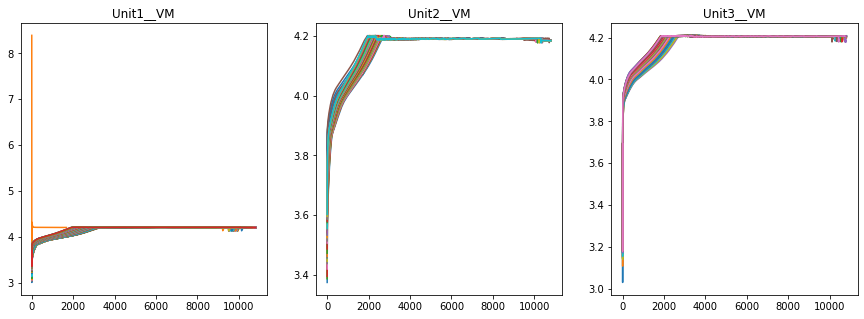

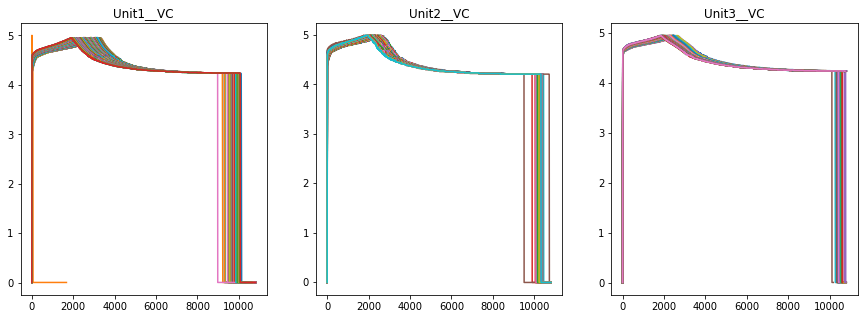

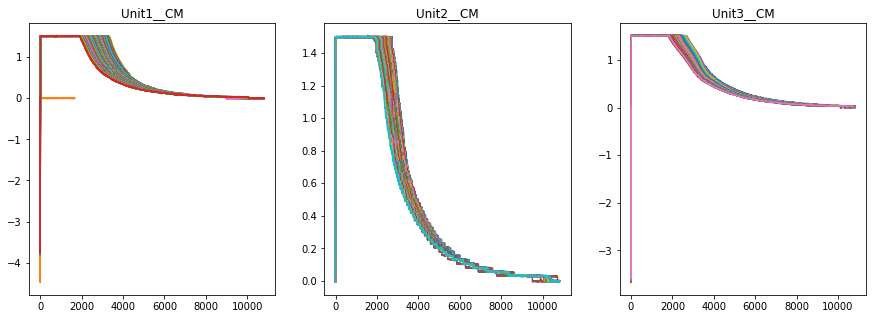

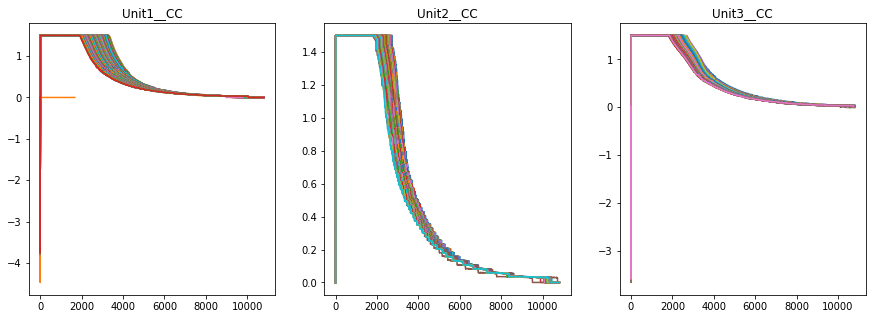

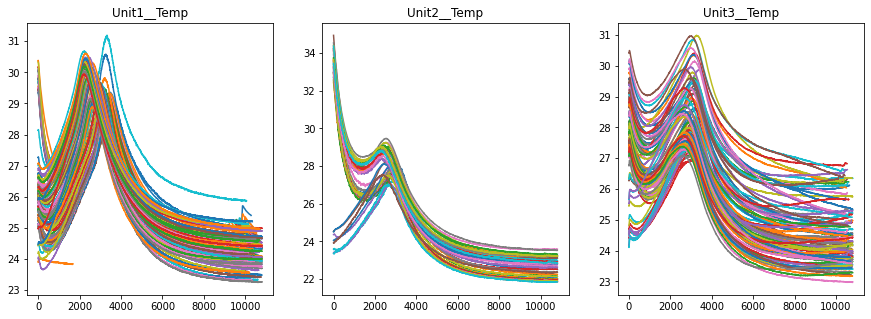

In [19]:
#プロット(充電)
mode = 'Charge'

cycles_1 = df_unit_1['Cycle'].unique()
cycles_2 = df_unit_2['Cycle'].unique()
cycles_3 = df_unit_3['Cycle'].unique()

for feature in col_charge:

  fig = plt.figure()
  fig.set_figwidth(15)
  fig.set_figheight(5)

  ax1 = fig.add_subplot(1, 3, 1)#ユニット1用
  ax2 = fig.add_subplot(1, 3, 2)#ユニット2用
  ax3 = fig.add_subplot(1, 3, 3)#ユニット3用

  for cycle in cycles_1:
    df_plot_1 = df_unit_1
    plot_x_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)]['Time']
    plot_y_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)][feature]
    ax1.plot(plot_x_1, plot_y_1)
    ax1.set_title(f'Unit1__{feature}')
    #ax.set_xticks(np.arange(0, cutoff_time, 1000))
    #ax.set_ylim(3, 5)

  for cycle in cycles_2:
    df_plot_2 = df_unit_2
    plot_x_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)]['Time']
    plot_y_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)][feature]
    ax2.plot(plot_x_2, plot_y_2)
    ax2.set_title(f'Unit2__{feature}')

  for cycle in cycles_3:
    df_plot_3 = df_unit_3
    plot_x_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)]['Time']
    plot_y_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)][feature]
    ax3.plot(plot_x_3, plot_y_3, label= f'Unit3__{feature}__{cycle}Cycle')
    ax3.set_title(f'Unit3__{feature}')

  #plt.legend()
  plt.show()

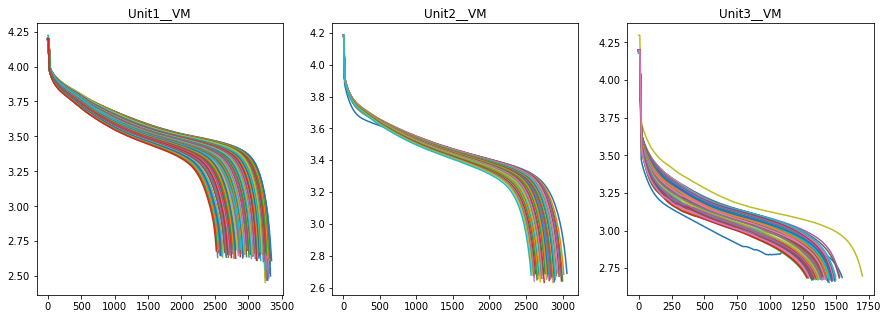

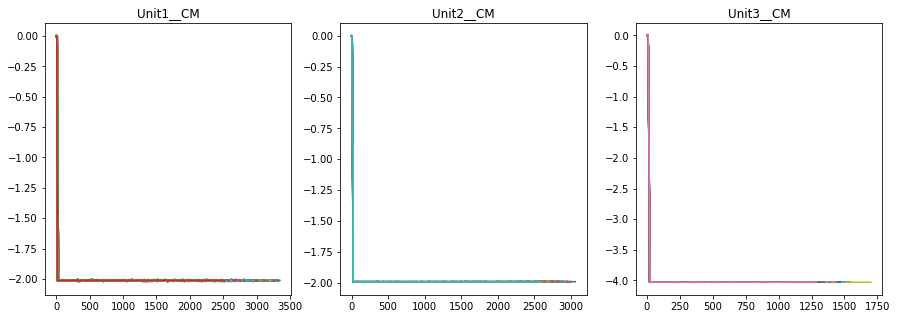

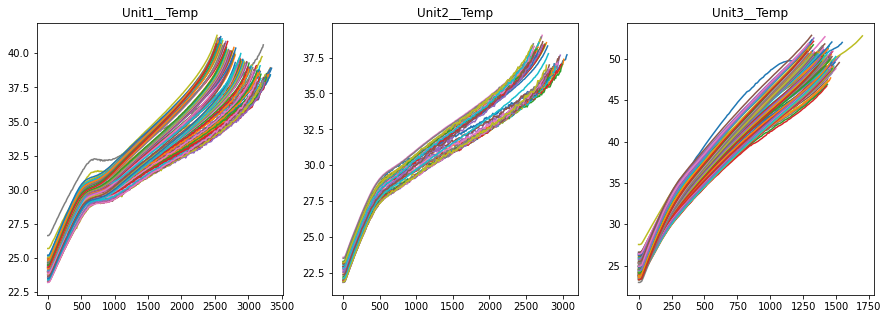

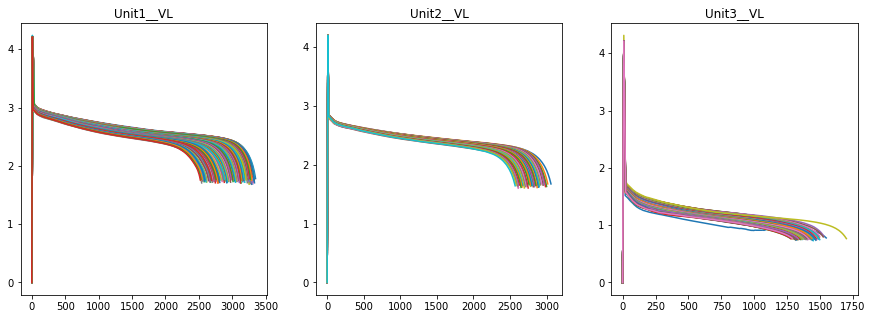

In [20]:
#プロット(放電)
mode = 'Discharge'

cycles_1 = df_unit_1['Cycle'].unique()
cycles_2 = df_unit_2['Cycle'].unique()
cycles_3 = df_unit_3['Cycle'].unique()

for feature in col_discharge:

  fig = plt.figure()
  fig.set_figwidth(15)
  fig.set_figheight(5)

  ax1 = fig.add_subplot(1, 3, 1)#ユニット1用
  ax2 = fig.add_subplot(1, 3, 2)#ユニット2用
  ax3 = fig.add_subplot(1, 3, 3)#ユニット3用

  for cycle in cycles_1:
    df_plot_1 = df_unit_1
    plot_x_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)]['Time']
    plot_y_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)][feature]
    ax1.plot(plot_x_1, plot_y_1)
    ax1.set_title(f'Unit1__{feature}')
    #ax.set_xticks(np.arange(0, cutoff_time, 1000))
    #ax.set_ylim(3, 5)

  for cycle in cycles_2:
    df_plot_2 = df_unit_2
    plot_x_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)]['Time']
    plot_y_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)][feature]
    ax2.plot(plot_x_2, plot_y_2)
    ax2.set_title(f'Unit2__{feature}')

  for cycle in cycles_3:
    df_plot_3 = df_unit_3
    plot_x_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)]['Time']
    plot_y_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)][feature]
    ax3.plot(plot_x_3, plot_y_3, label= f'Unit3__{feature}__{cycle}Cycle')
    ax3.set_title(f'Unit3__{feature}')

  #plt.legend()
  plt.show()

生波形データ加工のポイント  
①充電のunit_1は、外れ値処理が必要(該当サイクルの削除)  
②放電のunit_3は、外れ値処理が必要(該当サイクルの削除)  
③放電のCMは、対象の特徴量から外す。  

In [42]:
#①の外れ値処理
feature = 'VM'
mode = 'Charge'

#最大
outlier_idx = df_unit_1[df_unit_1['mode'] == mode][feature].idxmax()
#最小
#outlier_idx = df_unit_1[feature].idxmin()

df_unit_1.iloc[outlier_idx,]

Time                    0
VM                 8.3931
VC                  0.003
CM            -0.00066675
CC                      0
Temp               23.899
unit_name    Train_Unit_1
mode               Charge
Cycle                  32
VL                    NaN
CL                    NaN
Name: 34406, dtype: object

In [45]:
#32サイクル目を除去。(=Cycle=32でないもののみ、抜き出し。)
df_unit_1 = df_unit_1[df_unit_1['Cycle'] !=32]

In [43]:
#③の外れ値処理
#timeが750時点における最小最大を確認する。
feature = 'VM'
mode = 'Discharge'

#最大
max_outlier_idx = df_unit_3[ (df_unit_3['mode'] == mode) & (740 < df_unit_3['Time']) & ( df_unit_3['Time'] < 760)][feature].idxmax()
#最小
min_outlier_idx = df_unit_3[ (df_unit_3['mode'] == mode) & (740 < df_unit_3['Time']) & ( df_unit_3['Time'] < 760)][feature].idxmin()

print('max:', df_unit_3.iloc[max_outlier_idx,])
print('-'*10)
print('min:', df_unit_3.iloc[min_outlier_idx,])

max: Time               750.81
VM                 3.1819
VC                    NaN
CM                -4.0276
CC                    NaN
Temp               42.025
unit_name    Train_Unit_3
mode            Discharge
Cycle                  39
VL                  1.213
CL                  3.996
Name: 107893, dtype: object
----------
min: Time               751.99
VM                 2.9119
VC                    NaN
CM                -4.0235
CC                    NaN
Temp                44.75
unit_name    Train_Unit_3
mode            Discharge
Cycle                   1
VL                  0.983
CL                  3.995
Name: 3452, dtype: object


In [51]:
#1サイクル目、39サイクル目を除去。(=Cycle=1でないもののみ、抜き出し。)
df_unit_3 = df_unit_3[(df_unit_3['Cycle'] !=1) & (df_unit_3['Cycle'] !=39)]

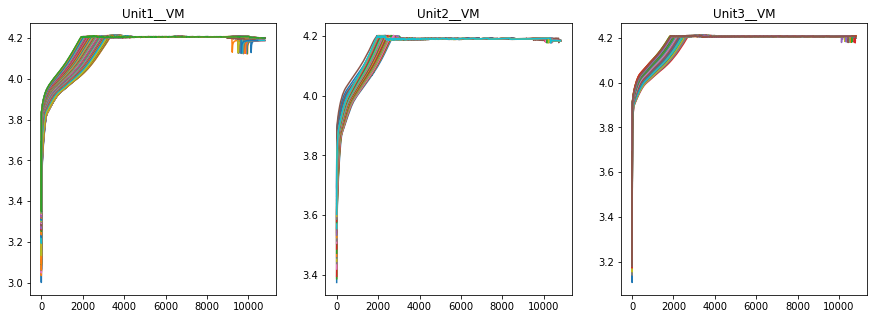

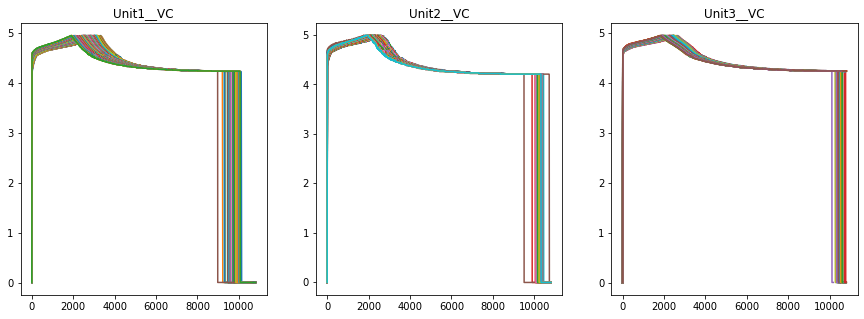

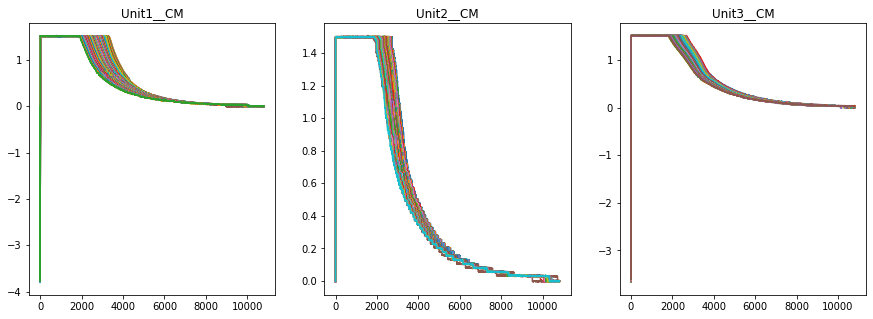

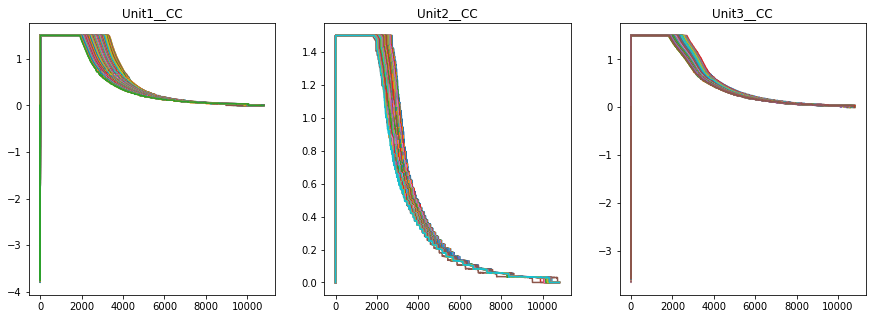

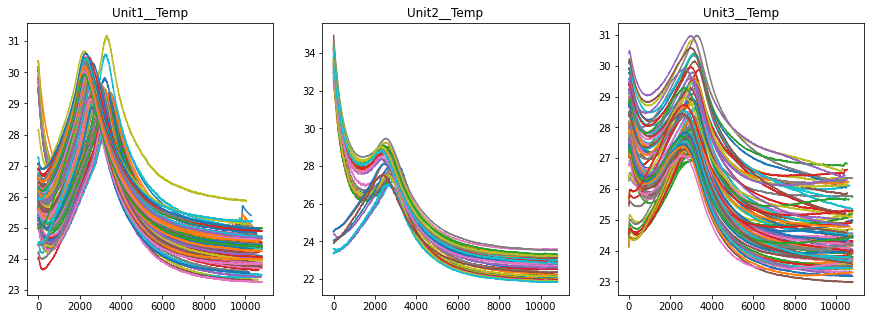

In [46]:
#プロット(充電)
mode = 'Charge'

cycles_1 = df_unit_1['Cycle'].unique()
cycles_2 = df_unit_2['Cycle'].unique()
cycles_3 = df_unit_3['Cycle'].unique()

for feature in col_charge:

  fig = plt.figure()
  fig.set_figwidth(15)
  fig.set_figheight(5)

  ax1 = fig.add_subplot(1, 3, 1)#ユニット1用
  ax2 = fig.add_subplot(1, 3, 2)#ユニット2用
  ax3 = fig.add_subplot(1, 3, 3)#ユニット3用

  for cycle in cycles_1:
    df_plot_1 = df_unit_1
    plot_x_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)]['Time']
    plot_y_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)][feature]
    ax1.plot(plot_x_1, plot_y_1)
    ax1.set_title(f'Unit1__{feature}')
    #ax.set_xticks(np.arange(0, cutoff_time, 1000))
    #ax.set_ylim(3, 5)

  for cycle in cycles_2:
    df_plot_2 = df_unit_2
    plot_x_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)]['Time']
    plot_y_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)][feature]
    ax2.plot(plot_x_2, plot_y_2)
    ax2.set_title(f'Unit2__{feature}')

  for cycle in cycles_3:
    df_plot_3 = df_unit_3
    plot_x_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)]['Time']
    plot_y_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)][feature]
    ax3.plot(plot_x_3, plot_y_3, label= f'Unit3__{feature}__{cycle}Cycle')
    ax3.set_title(f'Unit3__{feature}')

  #plt.legend()
  plt.show()

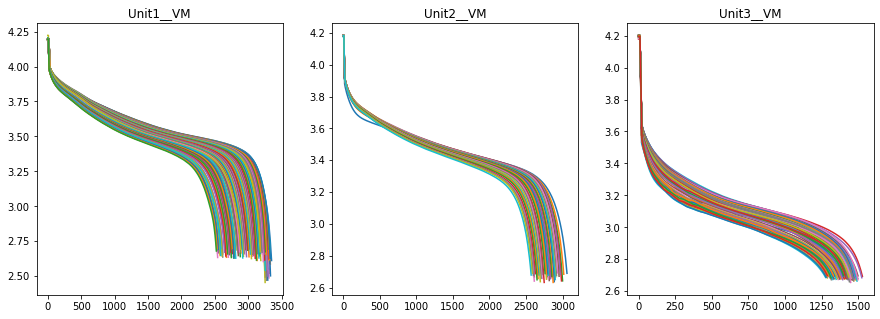

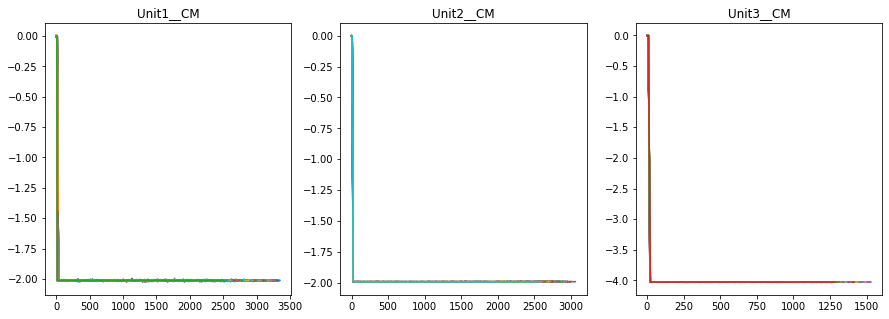

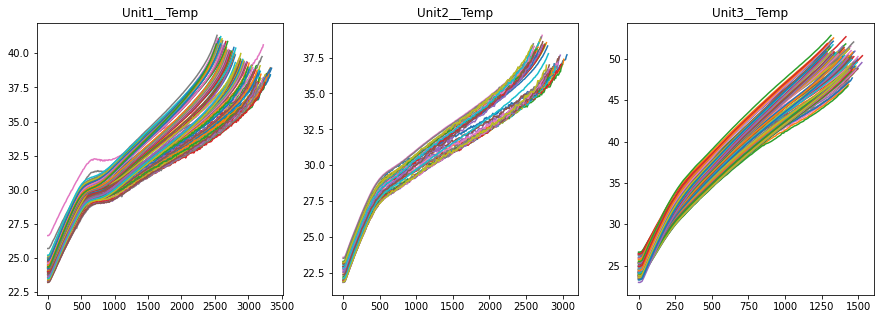

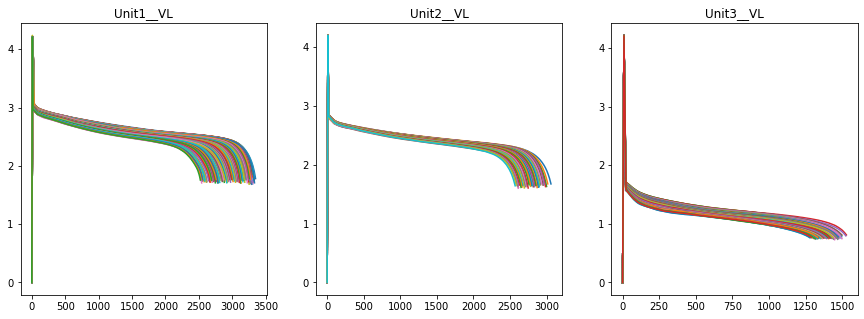

In [52]:
#プロット(放電)
mode = 'Discharge'

cycles_1 = df_unit_1['Cycle'].unique()
cycles_2 = df_unit_2['Cycle'].unique()
cycles_3 = df_unit_3['Cycle'].unique()

for feature in col_discharge:

  fig = plt.figure()
  fig.set_figwidth(15)
  fig.set_figheight(5)

  ax1 = fig.add_subplot(1, 3, 1)#ユニット1用
  ax2 = fig.add_subplot(1, 3, 2)#ユニット2用
  ax3 = fig.add_subplot(1, 3, 3)#ユニット3用

  for cycle in cycles_1:
    df_plot_1 = df_unit_1
    plot_x_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)]['Time']
    plot_y_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)][feature]
    ax1.plot(plot_x_1, plot_y_1)
    ax1.set_title(f'Unit1__{feature}')
    #ax.set_xticks(np.arange(0, cutoff_time, 1000))
    #ax.set_ylim(3, 5)

  for cycle in cycles_2:
    df_plot_2 = df_unit_2
    plot_x_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)]['Time']
    plot_y_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)][feature]
    ax2.plot(plot_x_2, plot_y_2)
    ax2.set_title(f'Unit2__{feature}')

  for cycle in cycles_3:
    df_plot_3 = df_unit_3
    plot_x_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)]['Time']
    plot_y_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)][feature]
    ax3.plot(plot_x_3, plot_y_3, label= f'Unit3__{feature}__{cycle}Cycle')
    ax3.set_title(f'Unit3__{feature}')

  #plt.legend()
  plt.show()